<a href="https://colab.research.google.com/github/ArturoAntonioSotoOsornio/DMUNAM2025/blob/JuarezClementeKarlaValeria_422058560/Pr%C3%A1ctica_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import pandas as pd
pd.set_option("display.max_columns",30)
pd.set_option("display.max_rows",3000)
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
cf.go_offline()
import numpy as np

### imputacion variables continuas
from sklearn.impute import SimpleImputer
from scipy.stats import ks_2samp

In [35]:
df = pd.read_csv("/content/drive/MyDrive/titanic.csv")

In [36]:
print("Dimensiones del dataset:", df.shape)
print("\nDistribución de supervivencia:")
print(df.survived.value_counts(normalize=True))

Dimensiones del dataset: (1310, 14)

Distribución de supervivencia:
survived
0.0    0.618029
1.0    0.381971
Name: proportion, dtype: float64


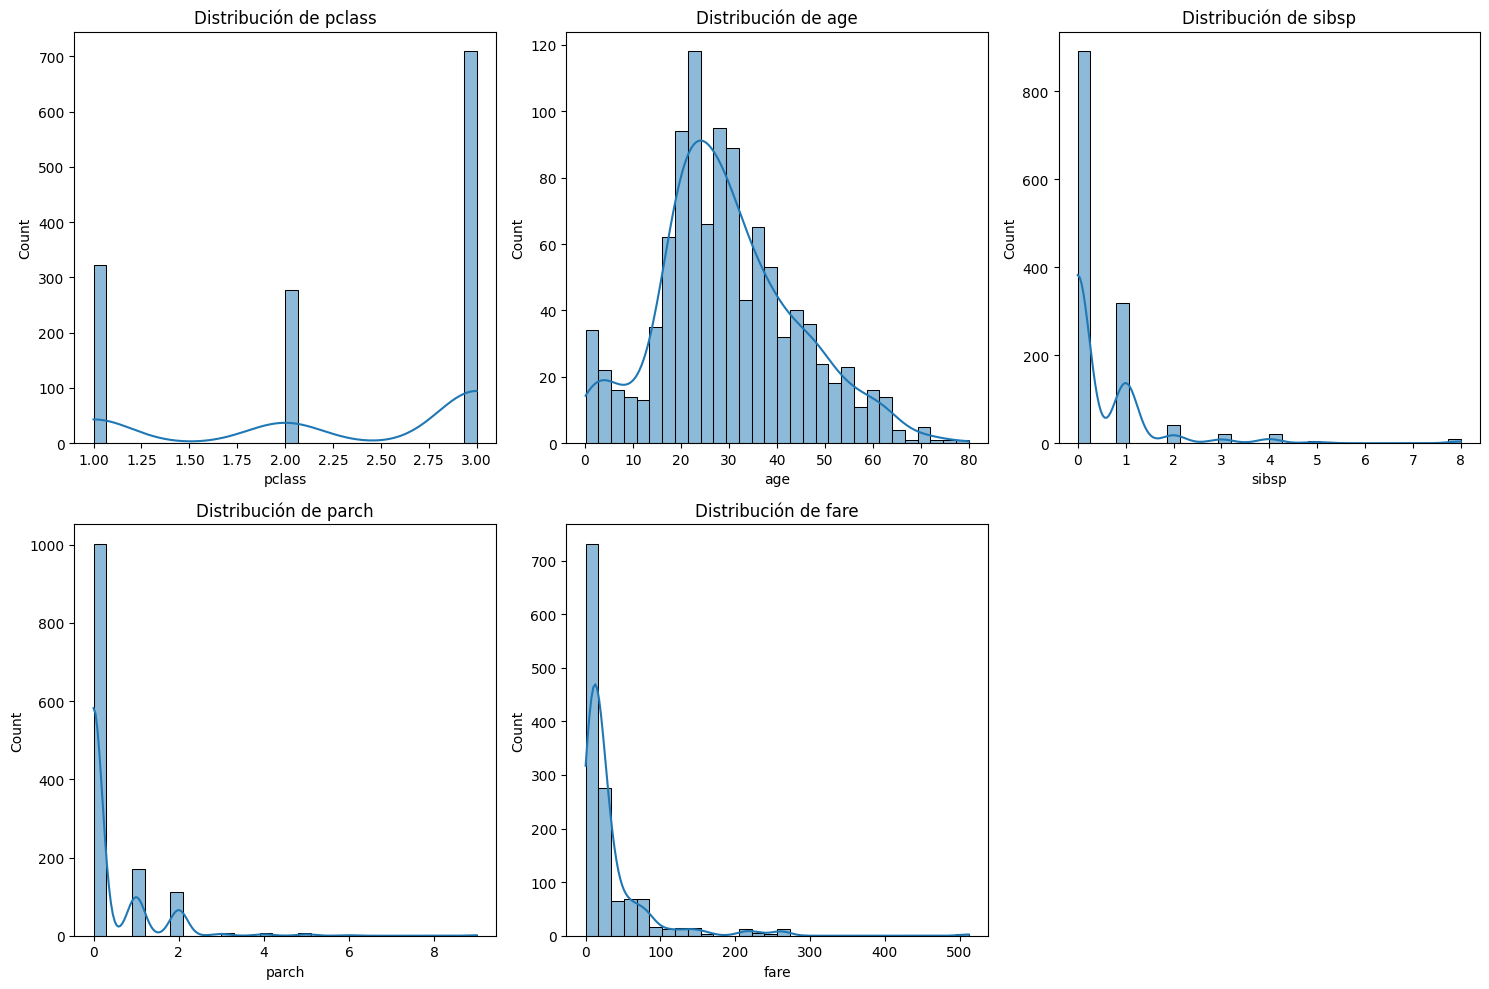

In [37]:
# Visualización de la distribución de características
plt.figure(figsize=(15,10))
for i, col in enumerate(['pclass', 'age', 'sibsp', 'parch', 'fare']):
    plt.subplot(2, 3, i+1)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribución de {col}')
plt.tight_layout()
plt.show()

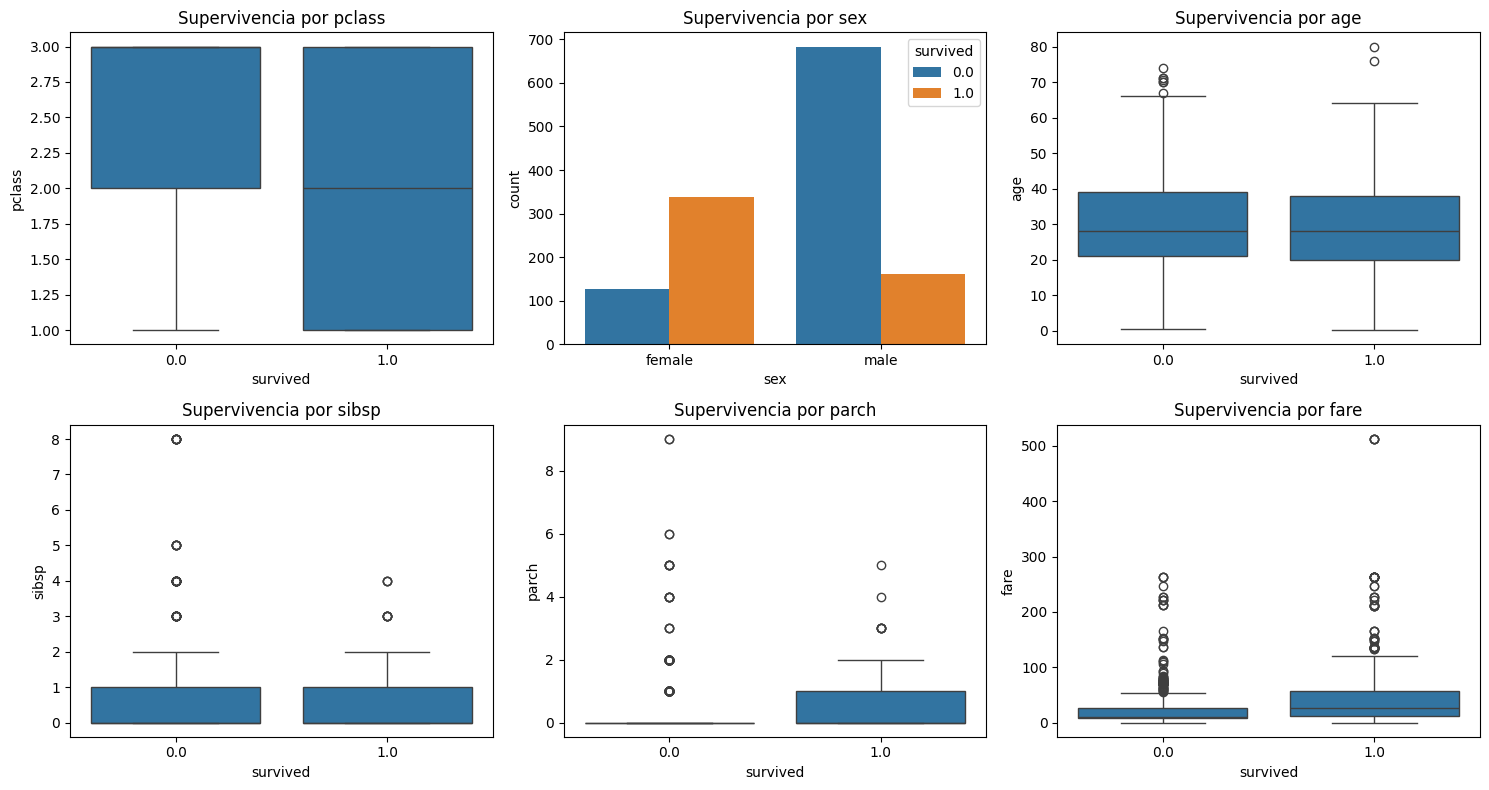

In [38]:
# Visualización de supervivencia por características
plt.figure(figsize=(15,8))
for i, col in enumerate(['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare']):
    plt.subplot(2, 3, i+1)
    if df[col].dtype in ['int64', 'float64']:
        sns.boxplot(x='survived', y=col, data=df)
    else:
        sns.countplot(x=col, hue='survived', data=df)
    plt.title(f'Supervivencia por {col}')
plt.tight_layout()
plt.show()

In [39]:
# Limpieza de datos
df = df[(~df["survived"].isnull()) & ~df["pclass"].isnull() & ~df["fare"].isnull()]

def completitud_datos_nulos(df):
    return df.isnull().sum().sort_values(ascending=False) / df.shape[0]

print("\nPorcentaje de valores nulos por columna:")
print(completitud_datos_nulos(df))

def complete_continuous_variables(df, col, strategy='median'):
    X = df[col].copy()
    im = SimpleImputer(strategy=strategy)
    Xi = pd.DataFrame(im.fit_transform(X), columns=col)
    l_ks = []
    for v in col:
        l_ks.append([v, ks_2samp(X[v].dropna(), Xi[v]).statistic])
    ks = pd.DataFrame(l_ks, columns=['feat','ks'])
    print((ks.ks>=0.1).sum())
    df[col] = im.transform(df[col].copy())
    return df


Porcentaje de valores nulos por columna:
body         0.908257
cabin        0.774465
boat         0.628440
home.dest    0.430428
age          0.201070
embarked     0.001529
sibsp        0.000000
sex          0.000000
name         0.000000
survived     0.000000
pclass       0.000000
fare         0.000000
parch        0.000000
ticket       0.000000
dtype: float64


In [40]:
df = complete_continuous_variables(df, ["age", "body"])

1


In [41]:
df['sex'] = df['sex'].map({'male': 0, 'female': 1})
df['embarked'] = df['embarked'].map({'S': 0, 'C': 1, 'Q': 2}).fillna(0)

In [42]:
df['family_size'] = df['sibsp'] + df['parch'] + 1
df['is_alone'] = (df['family_size'] == 1).astype(int)
df['fare_per_person'] = df['fare'] / df['family_size']

In [43]:
varc = list(df.describe().columns)
varc = [x for x in varc if x not in ['survived', 'body']]  # Eliminar body por muchos nulos
vard = [x for x in df.columns if x not in varc + ['survived', 'name', 'ticket', 'cabin', 'boat']]

tgt = 'survived'

In [44]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

In [46]:
X = df[varc].copy()
y = df[tgt].copy().astype(int)

sc = MinMaxScaler()
Xs = pd.DataFrame(sc.fit_transform(X), columns=varc)

Xt, Xv, yt, yv = train_test_split(Xs, y, train_size=0.7, random_state=42, stratify=y)

def entrenar(param, modelo, X, y):
    grid = RandomizedSearchCV(param_distributions=param,
                             n_jobs=-1,
                             n_iter=20,
                             cv=5,
                             scoring='roc_auc',
                             estimator=modelo,
                             error_score='raise',
                             random_state=42)
    grid.fit(X, y)
    return grid, grid.best_estimator_, grid.best_score_, grid.best_params_

def metricas(Xt, Xv, yt, yv, modelo):
    d = {'train': round(roc_auc_score(y_true=yt, y_score=modelo.predict_proba(Xt)[:,1]), 3),
         'validate': round(roc_auc_score(y_true=yv, y_score=modelo.predict_proba(Xv)[:,1]), 3)}

    # Matriz de confusión
    y_pred = modelo.predict(Xv)
    cm = confusion_matrix(yv, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Matriz de Confusión')
    plt.xlabel('Predicho')
    plt.ylabel('Real')
    plt.show()

    # Reporte de clasificación
    print(classification_report(yv, y_pred))

    return d


Red Neuronal

In [47]:
from sklearn.neural_network import MLPClassifier


****** Red Neuronal ******
Mejores parámetros: {'solver': 'adam', 'max_iter': 500, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (50, 30, 20), 'early_stopping': True, 'batch_size': 32, 'alpha': 0.0001, 'activation': 'relu'}
Mejor puntuación en validación cruzada: 0.8251833122629583


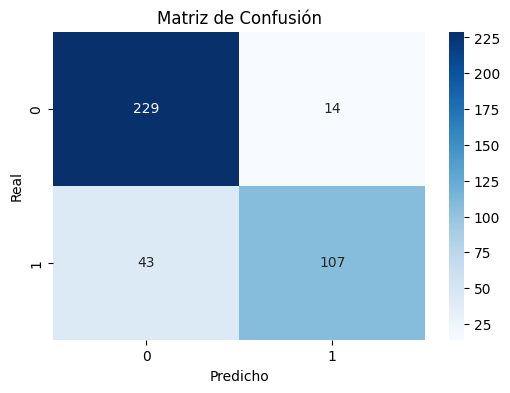

              precision    recall  f1-score   support

           0       0.84      0.94      0.89       243
           1       0.88      0.71      0.79       150

    accuracy                           0.85       393
   macro avg       0.86      0.83      0.84       393
weighted avg       0.86      0.85      0.85       393

Métricas finales: {'train': np.float64(0.85), 'validate': np.float64(0.887)}


In [49]:
print("\n****** Red Neuronal ******")
param_mlpc = {
    'hidden_layer_sizes': [(50,), (100,), (50,50), (100,50), (100,100), (50,30,20)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'batch_size': [32, 64],
    'learning_rate': ['adaptive'],
    'early_stopping': [True],
    'max_iter': [500]
}

modelo_mlpc = MLPClassifier(random_state=42)
modelo_mlpc, best_estimator_mlpc, score_mlpc, params_mlpc = entrenar(param_mlpc, modelo_mlpc, Xt, yt)
print("Mejores parámetros:", params_mlpc)
print("Mejor puntuación en validación cruzada:", score_mlpc)
print("Métricas finales:", metricas(Xt, Xv, yt, yv, best_estimator_mlpc))

Random Forest

In [50]:
from sklearn.ensemble import RandomForestClassifier


****** Random Forest ******
Mejores parámetros: {'random_state': 42, 'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'class_weight': None, 'bootstrap': True}
Mejor puntuación en validación cruzada: 0.8439823008849558


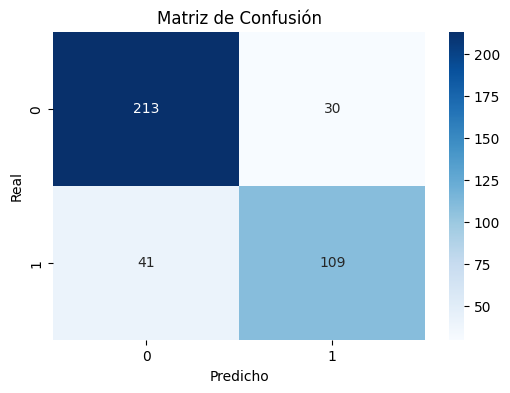

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       243
           1       0.78      0.73      0.75       150

    accuracy                           0.82       393
   macro avg       0.81      0.80      0.81       393
weighted avg       0.82      0.82      0.82       393

Métricas finales: {'train': np.float64(0.973), 'validate': np.float64(0.871)}


In [51]:
print("\n****** Random Forest ******")
param_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True],
    'class_weight': ['balanced', None],
    'random_state': [42]
}

modelo_rf = RandomForestClassifier()
modelo_rf, best_estimator_rf, score_rf, params_rf = entrenar(param_rf, modelo_rf, Xt, yt)
print("Mejores parámetros:", params_rf)
print("Mejor puntuación en validación cruzada:", score_rf)
print("Métricas finales:", metricas(Xt, Xv, yt, yv, best_estimator_rf))

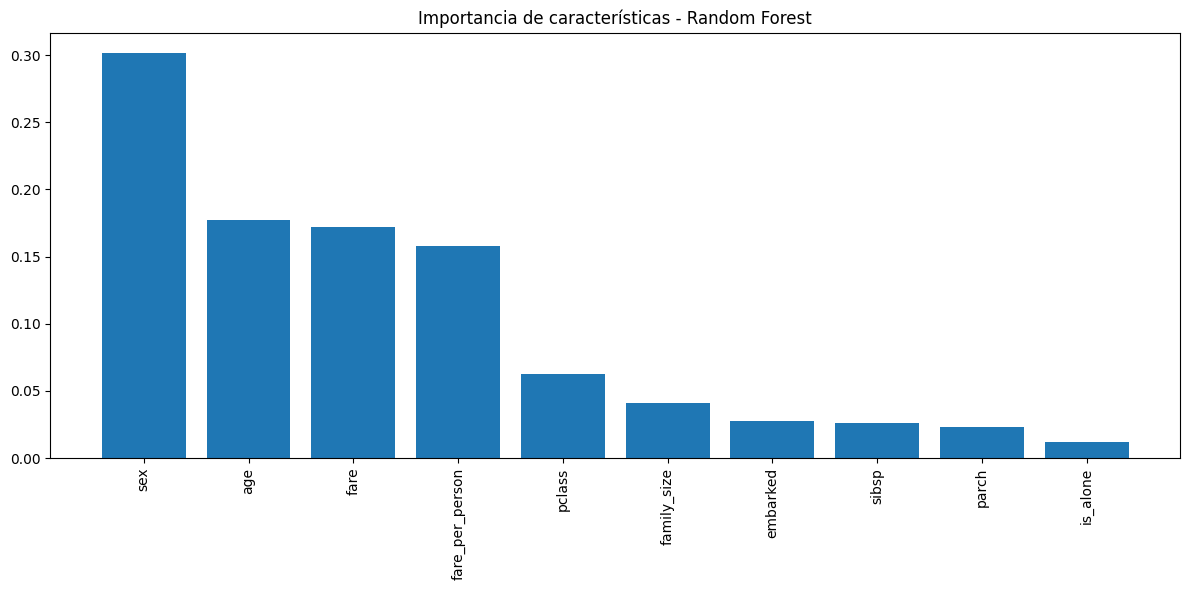

In [52]:
importances = best_estimator_rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12,6))
plt.title("Importancia de características - Random Forest")
plt.bar(range(Xt.shape[1]), importances[indices], align="center")
plt.xticks(range(Xt.shape[1]), [varc[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

Ada Boost

In [53]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


****** AdaBoost ******


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning:

The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning:

The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.



Mejores parámetros: {'n_estimators': 100, 'learning_rate': 0.5, 'estimator': DecisionTreeClassifier(max_depth=1, random_state=42), 'algorithm': 'SAMME'}
Mejor puntuación en validación cruzada: 0.8230467762326169


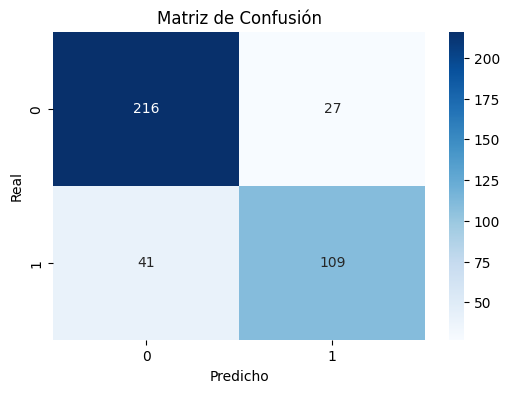

              precision    recall  f1-score   support

           0       0.84      0.89      0.86       243
           1       0.80      0.73      0.76       150

    accuracy                           0.83       393
   macro avg       0.82      0.81      0.81       393
weighted avg       0.83      0.83      0.83       393

Métricas finales: {'train': np.float64(0.843), 'validate': np.float64(0.872)}


In [54]:
print("\n****** AdaBoost ******")
param_adab = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5, 1.0],
    'algorithm': ['SAMME'],  # Solo SAMME para mayor compatibilidad
    'estimator': [DecisionTreeClassifier(max_depth=1, random_state=42)]  # Siempre usamos DecisionTree
}

modelo_adab = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1, random_state=42),
    random_state=42
)
modelo_adab, best_estimator_adab, score_adab, params_adab = entrenar(param_adab, modelo_adab, Xt, yt)
print("Mejores parámetros:", params_adab)
print("Mejor puntuación en validación cruzada:", score_adab)
print("Métricas finales:", metricas(Xt, Xv, yt, yv, best_estimator_adab))

Análisis Discriminante

In [55]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.utils.validation import check_X_y


****** Análisis Discriminante ******
Error en LDA: shrinkage not supported with 'svd' solver.
Usando modelo LDA simple con solver='svd'


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning:

The total space of parameters 15 is smaller than n_iter=20. Running 15 iterations. For exhaustive searches, use GridSearchCV.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but LinearDiscriminantAnalysis was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but LinearDiscriminantAnalysis was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but LinearDiscriminantAnalysis was fitted without feature names



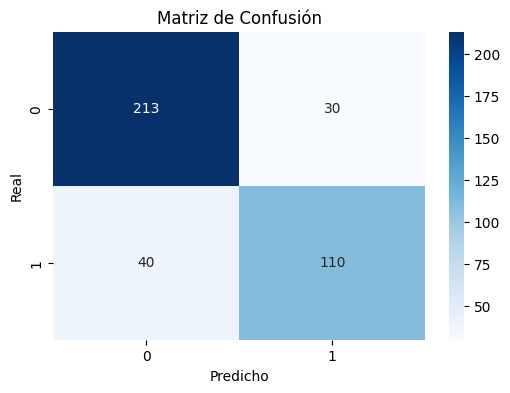

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       243
           1       0.79      0.73      0.76       150

    accuracy                           0.82       393
   macro avg       0.81      0.80      0.81       393
weighted avg       0.82      0.82      0.82       393

Métricas finales: {'train': np.float64(0.831), 'validate': np.float64(0.875)}


In [56]:
print("\n****** Análisis Discriminante ******")
param_lda = {
    'solver': ['svd'],  # Usamos solo svd que es más estable
    'shrinkage': [None, 'auto', 0.1, 0.5, 0.9],
    'tol': [1e-4, 1e-3, 1e-2]
}

Xt_checked, yt_checked = check_X_y(Xt, yt)

modelo_lda = LinearDiscriminantAnalysis(solver='svd')
try:
    modelo_lda, best_estimator_lda, score_lda, params_lda = entrenar(param_lda, modelo_lda, Xt_checked, yt_checked)
    print("Mejores parámetros:", params_lda)
    print("Mejor puntuación en validación cruzada:", score_lda)
    print("Métricas finales:", metricas(Xt, Xv, yt, yv, best_estimator_lda))
except Exception as e:
    print(f"Error en LDA: {str(e)}")
    # Alternativa si falla el ajuste con parámetros
    modelo_lda_simple = LinearDiscriminantAnalysis(solver='svd')
    modelo_lda_simple.fit(Xt_checked, yt_checked)
    print("Usando modelo LDA simple con solver='svd'")
    print("Métricas finales:", metricas(Xt, Xv, yt, yv, modelo_lda_simple))

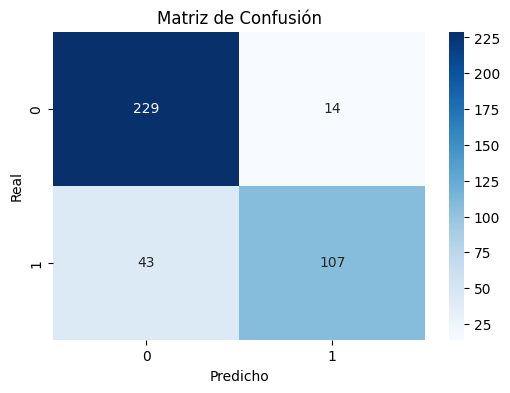

              precision    recall  f1-score   support

           0       0.84      0.94      0.89       243
           1       0.88      0.71      0.79       150

    accuracy                           0.85       393
   macro avg       0.86      0.83      0.84       393
weighted avg       0.86      0.85      0.85       393



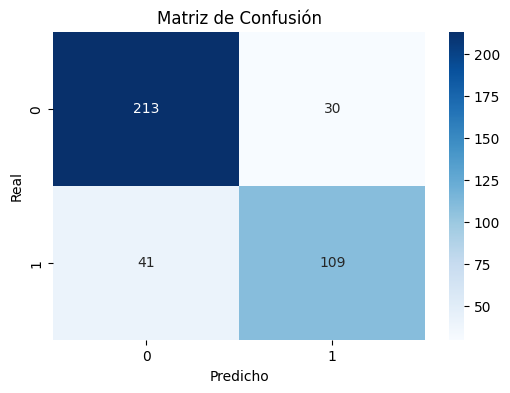

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       243
           1       0.78      0.73      0.75       150

    accuracy                           0.82       393
   macro avg       0.81      0.80      0.81       393
weighted avg       0.82      0.82      0.82       393



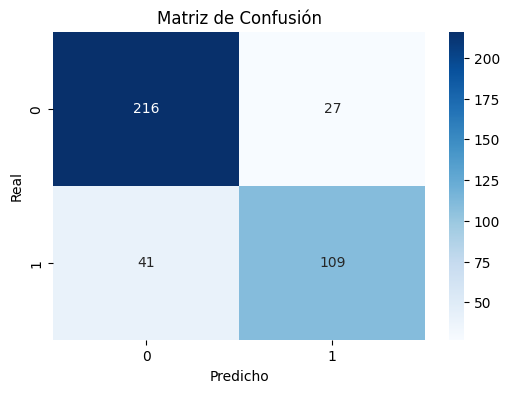

              precision    recall  f1-score   support

           0       0.84      0.89      0.86       243
           1       0.80      0.73      0.76       150

    accuracy                           0.83       393
   macro avg       0.82      0.81      0.81       393
weighted avg       0.83      0.83      0.83       393



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but LinearDiscriminantAnalysis was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but LinearDiscriminantAnalysis was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but LinearDiscriminantAnalysis was fitted without feature names



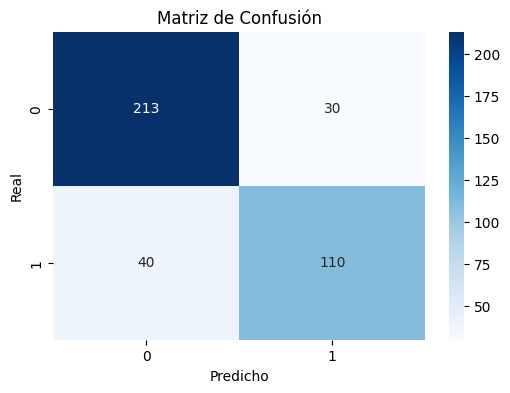

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       243
           1       0.79      0.73      0.76       150

    accuracy                           0.82       393
   macro avg       0.81      0.80      0.81       393
weighted avg       0.82      0.82      0.82       393



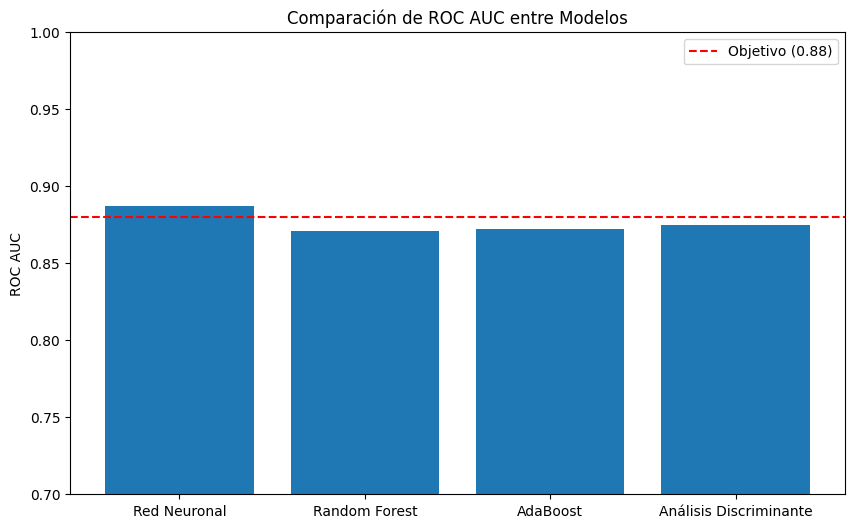

In [57]:
# Comparativa de modelos
resultados = {
    'Red Neuronal': metricas(Xt, Xv, yt, yv, best_estimator_mlpc)['validate'],
    'Random Forest': metricas(Xt, Xv, yt, yv, best_estimator_rf)['validate'],
    'AdaBoost': metricas(Xt, Xv, yt, yv, best_estimator_adab)['validate'],
    'Análisis Discriminante': metricas(Xt, Xv, yt, yv, best_estimator_lda if 'best_estimator_lda' in locals() else modelo_lda_simple)['validate']
}

plt.figure(figsize=(10,6))
plt.bar(resultados.keys(), resultados.values())
plt.axhline(y=0.88, color='r', linestyle='--', label='Objetivo (0.88)')
plt.title('Comparación de ROC AUC entre Modelos')
plt.ylabel('ROC AUC')
plt.ylim(0.7, 1.0)
plt.legend()
plt.show()

In [58]:
import pickle

In [59]:
best_model = max([
    (best_estimator_mlpc, resultados['Red Neuronal']),
    (best_estimator_rf, resultados['Random Forest']),
    (best_estimator_adab, resultados['AdaBoost']),
    (best_estimator_lda if 'best_estimator_lda' in locals() else modelo_lda_simple, resultados['Análisis Discriminante'])
], key=lambda x: x[1])[0]

filename = 'best_model_titanic.pkl'
with open(filename, 'wb') as file:
    pickle.dump(best_model, file)
print(f"\nMejor modelo guardado como {filename}")


Mejor modelo guardado como best_model_titanic.pkl


Conclusión:

Se realizó una limpieza, es decir, se eliminaron los valores nulos en variables críticas, también se crearon algunas variables para capturar patrones ocultos.
Se logró optimizar 4 modelos, además, se utilizarton algunos gráficos y métricas como ROC AUC para evaluar la capacidad predictiva.